In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import cvxpy
from cvxpy import *
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
seed = np.random.seed(500)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sattl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sattl\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sattl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sattl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\sattl\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Read in the .csv file pertaining to the dataset: https://zenodo.org/record/2575509#.XodGuIhKiCo from paper doi: 10.5281/zenodo.2575509. We will look at the polarity of posts in stackexchange comments and create two models for prediction: A SVM model and a Naive Bayes model. 

In [2]:
test_file = 'test1326itemPOLARITY.csv'
train_file = 'train3098itemPOLARITY.csv'

In [3]:
df_train = pd.read_csv(train_file, delimiter = ';',names=['id','polarity','text'])
df_test = pd.read_csv(test_file, delimiter = ';',names=['id','polarity','text'])
firstText = df_train.iloc[0].text
print('Training Data')
print(df_train.head())
print('Testing Data')
print(df_test.head())

Training Data
   id  polarity                                               text
0  t1  negative  Vineet, what you are trying to do is a terribl...
1  t2  positive                           'Course I do, corrected.
2  t3  positive  Excellent, happy to help! If you don't mind, c...
3  t6  negative  @talnicolas I'm using it a few dozen times in ...
4  t7   neutral  I didn't select an answer because even though ...
Testing Data
    id  polarity                                               text
0   t4  positive  @DrabJay: excellent suggestion! Code changed. :-)
1   t5   neutral  Any decent browser should protect against mali...
2   t8  negative  I swear - I don't put pseudo code I get told o...
3   t9   neutral                              I have attached below
4  t13  negative  When I refactor the following line: using Resh...


Check the frequency of the three labels: positive, neutral, negative for the training set

{'neutral': 1186, 'positive': 1069, 'negative': 842}
{'neutral': 508, 'positive': 458, 'negative': 360}


<BarContainer object of 3 artists>

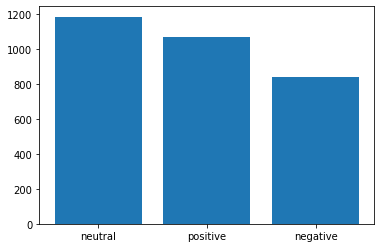

In [35]:
freq = df_train['polarity'].value_counts().to_dict()
print(freq)
print(df_test['polarity'].value_counts().to_dict())
plt.bar(freq.keys(),freq.values())

Dataset isn't too imbalanced, with majority in neutral. We will see how SVM(discrimitive) will act versus Naive Bayes(Generative). Before pre-processing, check data for any non-valid entries.

In [5]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3097 entries, 0 to 3096
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3097 non-null   object
 1   polarity  3097 non-null   object
 2   text      3097 non-null   object
dtypes: object(3)
memory usage: 72.7+ KB
None


For further pre-processing the following guide is followed: https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34.


In [6]:
def preprocess(dataframe):
    # double check, remove blank rows if any
    dataframe['text'].dropna(inplace=True)
    
    # Change text to lowercase
    dataframe['text'] = [entry.lower() for entry in dataframe['text']]
    
    # Remove non-english words/user names
    words = set(nltk.corpus.words.words())
    dataframe['text'] = [" ".join(w for w in nltk.wordpunct_tokenize(entry) if w.lower() in words or not w.isalpha()) for entry in dataframe['text']] 
    
    # Tokenize each entry of the corpus. 
    dataframe['text'] = [word_tokenize(entry) for entry in dataframe['text']]

    # Removing stop words, non-numeric and perform word stemming/lemmenting explained in the guide above.
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    for index,entry in enumerate(dataframe['text']):
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        # The final processed set of words for each iteration will be stored in 'text'
        dataframe.loc[index,'text'] = str(Final_words)
    return dataframe

In [7]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

Print head of train/test dataframe.

In [8]:
print('Training Data')
print(df_train.head())
print('Testing Data')
print(df_test.head())

Training Data
   id  polarity                                               text
0  t1  negative  ['try', 'terrible', 'idea', 'ever', 'find', 'e...
1  t2  positive                              ['course', 'correct']
2  t3  positive  ['excellent', 'happy', 'help', 'mind', 'accept...
3  t6  negative  ['dozen', 'time', 'class', 'heavy', 'write', '...
4  t7   neutral  ['select', 'answer', 'even', 'though', 'two', ...
Testing Data
    id  polarity                                               text
0   t4  positive                ['excellent', 'suggestion', 'code']
1   t5   neutral  ['decent', 'browser', 'protect', 'malicious', ...
2   t8  negative  ['swear', 'put', 'pseudo', 'code', 'get', 'tel...
3   t9   neutral                                         ['attach']
4  t13  negative  ['following', 'line', 'use', 'object', 'get', ...


Show the original first text and pre-processed text as comparison.

In [9]:
print('Original Sentence')
print(firstText)
print('')
print('Preprocessed Sentence')
print(df_train.iloc[0].text)

Original Sentence
Vineet, what you are trying to do is a terrible idea! If you ever find yourself having to engineer something as fundamental as that, take a step back and work out what else does it! I don't really believe in the whole spoon fed SO thing, but what mtwebster says is on the right track!

Preprocessed Sentence
['try', 'terrible', 'idea', 'ever', 'find', 'engineer', 'something', 'fundamental', 'take', 'step', 'back', 'work', 'else', 'really', 'believe', 'whole', 'spoon', 'feed', 'thing', 'right', 'track']


You can see some words being lemmatized including fed -> feed to create more general cases. Usernames are removed and words are all lowercased. The next step is to encode the target variable.

In [10]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
train_labels = Encoder.fit_transform(df_train['polarity'])
test_labels = Encoder.fit_transform(df_test['polarity'])

Below shows the new labels encoded with numerical values.
Negative = 0
Positive = 2
Neutral = 1

In [11]:
print(train_labels[0:5])
print(df_train.iloc[0:5].polarity)

[0 2 2 0 1]
0    negative
1    positive
2    positive
3    negative
4     neutral
Name: polarity, dtype: object


The next step is word vectorization. The most popular vectorization method is called Term Frequency-Inverse Document Frequency (TF-IDF). The largest con of this word is not being able to caputre the semantics of sentence structure. We will cap the max unique words to 5000. Wikipedia link for TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(pd.concat([df_train,df_test]).text)

Train_X_Tfidf = Tfidf_vect.transform(df_train.text)
Test_X_Tfidf = Tfidf_vect.transform(df_test.text)

Below shows the vocabulary learned from both the train/test set.

In [13]:
vocab = Tfidf_vect.vocabulary_
print(vocab)

{'try': 3596, 'terrible': 3458, 'idea': 1637, 'ever': 1163, 'find': 1300, 'engineer': 1118, 'something': 3209, 'fundamental': 1412, 'take': 3422, 'step': 3290, 'back': 302, 'work': 3853, 'else': 1092, 'really': 2768, 'believe': 359, 'whole': 3819, 'spoon': 3256, 'feed': 1277, 'thing': 3483, 'right': 2939, 'track': 3547, 'course': 787, 'correct': 772, 'excellent': 1182, 'happy': 1538, 'help': 1563, 'mind': 2143, 'accept': 14, 'answer': 180, 'dozen': 1022, 'time': 3514, 'class': 592, 'heavy': 1556, 'write': 3875, 'easy': 1064, 'read': 2756, 'painful': 2408, 'sorry': 3218, 'think': 3485, 'question': 2707, 'subjective': 3335, 'maybe': 2087, 'someone': 3208, 'move': 2200, 'select': 3044, 'even': 1160, 'though': 3492, 'two': 3609, 'neither': 2245, 'complete': 669, 'tomcat': 3529, 'confusion': 715, 'bliss': 398, 'state': 3279, 'single': 3147, 'every': 1164, 'item': 1843, 'application': 205, 'en': 1105, 'library': 1942, 'system': 3414, 'may': 2085, 'way': 3788, 'globally': 1458, 'communicate':

Below shows the vectorized data for the training set. ex. (A, B)    C ->   A = Row #, B = Unique Integer # of each word in  row, C = Score calculated by TF-IDF Vectorizer. The C score will only be used in naive bayesian since we incorporate the known statistics.

In [14]:
print(Train_X_Tfidf)

  (0, 3853)	0.11724419285063631
  (0, 3819)	0.21347895368401706
  (0, 3596)	0.13222834134572298
  (0, 3547)	0.2533868926016408
  (0, 3483)	0.1826518687913262
  (0, 3458)	0.19394594561964495
  (0, 3422)	0.17964880242877448
  (0, 3290)	0.2509412774772344
  (0, 3256)	0.3297393905268176
  (0, 3209)	0.1679439778713673
  (0, 2939)	0.17788597843127688
  (0, 2768)	0.11938970255633906
  (0, 1637)	0.18304455502364803
  (0, 1412)	0.31437474343962013
  (0, 1300)	0.14357982446029607
  (0, 1277)	0.2822673380371457
  (0, 1163)	0.22350918218205862
  (0, 1118)	0.30347335284362326
  (0, 1092)	0.2077636888508591
  (0, 359)	0.23111337389883624
  (0, 302)	0.1966733009438299
  (1, 787)	0.7325496190689499
  (1, 772)	0.680713637003062
  (2, 2143)	0.5145908152851082
  (2, 1563)	0.31198520357099335
  :	:
  (3093, 48)	0.1781643831076544
  (3094, 3887)	0.3935593732037678
  (3094, 3875)	0.3196671157125581
  (3094, 3700)	0.417251087436555
  (3094, 3691)	0.5163342099608438
  (3094, 1275)	0.44962553180986065
  (3094,

The next step is incorporating the following algorithms: Naive Bayesian, SVM from sratch. For sanity check we will first use the skit-learn library to compare values. The following is Naive Bayesian:

In [26]:
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score

# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,train_labels)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
results = confusion_matrix(predictions_NB,test_labels)
print('Confusion Matrix')
print(results)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, test_labels)*100)
print('Report: ')
print(classification_report(test_labels,predictions_NB))

Confusion Matrix
[[163  33   3]
 [176 395  83]
 [ 21  80 372]]
Naive Bayes Accuracy Score ->  70.13574660633483
Report: 
              precision    recall  f1-score   support

           0       0.82      0.45      0.58       360
           1       0.60      0.78      0.68       508
           2       0.79      0.81      0.80       458

    accuracy                           0.70      1326
   macro avg       0.74      0.68      0.69      1326
weighted avg       0.73      0.70      0.69      1326



The following is SVM from sklearn:

In [30]:
from sklearn import svm

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,train_labels)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
results = confusion_matrix(predictions_SVM,test_labels)
print('Confusion Matrix')
print(results)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, test_labels)*100)
print('Report: ')
print(classification_report(test_labels,predictions_SVM))

Confusion Matrix
[[226  40  11]
 [128 436  79]
 [  6  32 368]]
SVM Accuracy Score ->  77.67722473604827
Report: 
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       360
           1       0.68      0.86      0.76       508
           2       0.91      0.80      0.85       458

    accuracy                           0.78      1326
   macro avg       0.80      0.76      0.77      1326
weighted avg       0.79      0.78      0.78      1326



Now that we have a rough estimate of our accurarcy, for comparison, lets start writing algorithms from scratch. 
We will first start with multinomial naive bayes.

Naive Bayes: A multinomial Naive Bayesian classifier was implemented, incorporating the statistics gained from TF-IDF scores.

In [17]:
### Training
# calculate probability of classes for train data
prob_neg = freq['negative']/len(train_labels)
prob_neutral = freq['neutral']/len(train_labels)
prob_pos = freq['positive']/len(train_labels)

print('Probability adds up to - > ' + str(prob_neg+prob_neutral+prob_pos))

Probability adds up to - > 1.0


In [18]:
# build pandas df w/ vectorized features for each class and add col for class
df_train_vect = pd.DataFrame(data = Train_X_Tfidf.toarray())
df_train_vect.insert(0,'class',train_labels,True)

# build df for seperate classes
df_neg = df_train_vect.loc[(df_train_vect['class'] == 0)].drop(['class'],axis=1)
df_neutral = df_train_vect.loc[(df_train_vect['class'] == 1)].drop(['class'],axis=1)
df_pos = df_train_vect.loc[(df_train_vect['class'] == 2)].drop(['class'],axis=1)

# total idf for each class
ni_neg = df_neg.sum().sum()
ni_neutral = df_neutral.sum().sum()
ni_pos = df_pos.sum().sum()

In [19]:
# create an array to store p(wi,ci) for each word, i.e. 3x3897 -> 3 for 3 classes, 3897 for unique words
# eq: P(wi,ci) = (nij + 1)/(ni+|V|)
word_prob = np.zeros((3,len(vocab)))

# for each word in vocab
for w in vocab:
    # word idx is vocab[w]
    wordIdx = int(vocab[w])
    
    ## for each class, calculate nij for each word
    # p(wi,ci) for negative
    word_prob[0,wordIdx] = (df_neg[wordIdx].sum()+1)/(ni_neg)
    
    # p(wi,ci) for neutral
    word_prob[1,wordIdx] = (df_neutral[wordIdx].sum()+1)/(ni_neutral)
    
    # p(wi,ci) for positive
    word_prob[2,wordIdx] = (df_pos[wordIdx].sum()+1)/(ni_pos)

What we will use from training to testing: The class probablities (i.e. prob_"") and the word postiers (i.e. word_prob)

In [31]:
### Testing
# prediction labels for testing set
prediction_labels = np.zeros(len(test_labels))

# build array w/ vectorized features 
test_vect = Test_X_Tfidf.toarray()

# for each entry (or document) calculate argmax of ci in C for P(ci)*product(P(ai|ci)) 
# where is ai is the word occuring at the ith position in X
for i in range(len(test_labels)):
    # setence
    X = test_vect[i]
    
    # words in X
    words_X = np.asarray(np.nonzero(X))[0]
    
    ## If no words in text after preprocessing, assume neutral
    if len(words_X) == 0:
        class_label = 1
    else:
        # prob of each word matrix, # of words by # of classes(3)
        prob_matrix = np.zeros((len(words_X),3))

        # compute probablities of each class
        for j in range(len(words_X)):
            # j corresponds to index of word in sentence
            ai = words_X[j]
            # negative
            prob_matrix[j,0] = word_prob[0,ai]
            # neutral
            prob_matrix[j,1] = word_prob[1,ai]
            # positive
            prob_matrix[j,2] = word_prob[2,ai]

        # take product of columns
        prod = np.prod(prob_matrix,axis=0)

        # highest prob associated with given class (neg = 0, neutral = 1, pos = 2). Multipy by p(class)
        class_label = np.argmax(prod*np.array([prob_neg,prob_neutral,prob_pos]))
    
    # store into prediction label
    prediction_labels[i] = class_label
    
    

Using more prior information (i.e. the TF-IDF score) we achieved a better accurarcy than sk-learn by ~4%. Below shows the confusion matrix for misclassified results. 

In [32]:
results = confusion_matrix(prediction_labels,test_labels)
print('Confusion Matrix')
print(results)
print("Naive Bayes Accuracy Score -> ",accuracy_score(prediction_labels, test_labels)*100)
print('Report: ')
print(classification_report(test_labels,prediction_labels))


Confusion Matrix
[[267  91  15]
 [ 76 329  45]
 [ 17  88 398]]
Naive Bayes Accuracy Score ->  74.96229260935144
Report: 
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       360
           1       0.73      0.65      0.69       508
           2       0.79      0.87      0.83       458

    accuracy                           0.75      1326
   macro avg       0.75      0.75      0.75      1326
weighted avg       0.75      0.75      0.75      1326



SVM: https://en.wikipedia.org/wiki/Support-vector_machine. For classes >2, we will use the 1 vs. 1 method where we will create M(M-1)/2 classifiers and use majority vote for classification. In this case we have M=3, so we will train 3 SVM classifiers: Positive vs Neutral, Neutral vs Negative, Negative vs Positive. If a tie occurs for all 3, neutral will be selected. Followed guide for reference: http://ecomunsing.com/build-your-own-support-vector-machine, we will be incorporating a robust linear discriminator.

In [22]:
### Training SVM
# set1 & set2, pd.to_numpy()
def svm_model(set1,set2):
    # dimensions of the hyperplane
    dim = set1.shape[1]
    
    # num of points in each class
    num1, num2 = set1.shape[0], set2.shape[0]
    
    # optimization using CvxPy
    a = Variable(dim)
    b = Variable()
    t = Variable()
    
    obj = Maximize(t)
    
    set1_contraints = [a.T * set1[i] - b >= t for i in range(num1)]
    set2_contraints = [a.T * set2[i] - b <= -t for i in range(num2)]
    
    contraints = set1_contraints + set2_contraints + [norm(a,2) <= 1]
    
    prob = Problem(obj, contraints)
    prob.solve()
    print("Problem Status: %s"%prob.status)
    return a.value, b.value, t.value

In [23]:
# PN1 - positive, negative
# PN2 - positive, neutral
# NN - negative neutral
PN1_a, PN1_b, PN1_t = svm_model(df_pos.to_numpy(),df_neg.to_numpy())
PN2_a, PN2_b, PN2_t = svm_model(df_pos.to_numpy(),df_neutral.to_numpy())
NN_a, NN_b, NN_t = svm_model(df_neg.to_numpy(),df_neutral.to_numpy())

Problem Status: optimal
Problem Status: optimal
Problem Status: optimal


In [33]:
### Testing SVM
# traverse through each document and classify w/ 3 classifier. Use majority rule.
for i in range(test_vect.shape[0]):
    doc = test_vect[i]
    # vote for each classifer, neutral = 0, negative = 1, positive = 2. Note: This is different from normal to allow np.argmax on
    # an even case to select neutral
    vote = np.zeros(3)
    
    # Positive vs Negative
    PN1_val = np.sum(PN1_a * doc) - PN1_b - PN1_t

    if PN1_val >= 0:
        vote[2] += 1
    else:
        vote[1] += 1 
    
    # Positive vs Neutral
    PN2_val = np.sum(PN2_a * doc) - PN2_b - PN2_t

    if PN2_val >= 0:
        vote[2] += 1
    else:
        vote[0] += 1 
    
    # Negative vs Neutral
    NN_val = np.sum(NN_a * doc) - NN_b - NN_t

    if NN_val >= 0:
        vote[1] += 1
    else:
        vote[0] += 1
        
    # Vote for class
    class_label = np.argmax(vote)
    
    # change 0 & 1 to reflect correct labels for neg/neutral
    if class_label == 0:
        class_label = 1
    elif class_label == 1:
        class_label = 0
    
    
    prediction_labels[i] = class_label
        

In [34]:
results = confusion_matrix(prediction_labels,test_labels)
print('Confusion Matrix')
print(results)
print("SVM Accuracy Score -> ",accuracy_score(prediction_labels, test_labels)*100)
print('Report: ')
print(classification_report(test_labels,prediction_labels))

Confusion Matrix
[[197 107  31]
 [133 313 140]
 [ 30  88 287]]
SVM Accuracy Score ->  60.10558069381599
Report: 
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       360
           1       0.53      0.62      0.57       508
           2       0.71      0.63      0.67       458

    accuracy                           0.60      1326
   macro avg       0.61      0.60      0.60      1326
weighted avg       0.61      0.60      0.60      1326

